# Runtime comparison of pandas crosstab, groupby and pivot_table

The pandas library is very powerful and offers several ways to group and summarize data. Typically, I use the `groupby` method but find `pivot_table` to be more readable. There is also `crosstab` as another alternative. In this notebook I'll do a short comparison of the runtime of `groupby`, `pivot_table` and `crosstab`. Let's first look at a DataFrame consisting of 10 columns and 100,000 rows of random integers between 1 and 100. The DataFrame will be grouped by the columns `A` and `B` counting the values in column `C`. The three operations result in data frames containing the same values.

In [1]:
%matplotlib inline
from string import ascii_uppercase

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('ramiro')
cols = list(ascii_uppercase[:10])
np.random.seed(42)
data = np.random.randint(1, 100, size=(100_000, 10))
df = pd.DataFrame(data, columns=cols)
df.head()

,A,B,C,D,E,F,G,H,I,J
0,52,93,15,72,61,21,83,87,75,75
1,88,24,3,22,53,2,88,30,38,2
2,64,60,21,33,76,58,22,89,49,91
3,59,42,92,60,80,15,62,62,47,62
4,51,55,64,3,51,7,21,73,39,18


In [2]:
%%timeit
df.groupby(['A', 'B'])['C'].count().unstack(fill_value=0)

8.3 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [3]:
%%timeit
df.pivot_table(values='C', index='A', columns='B', aggfunc='count', fill_value=0)

35.8 ms ± 666 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
%%timeit
pd.crosstab(index=df.A, columns=df.B)

72.1 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


For the first test case the `groupby` DataFrame method followed by calls to `count` and `unstack` is clearly the fastest way to do the calculation. I think the `pivot_table` option makes it more obvious what the result will look like, when spelling out the keyword arguments, but it is much slower. The `crosstab` option saves you some typing at the cost of being slow and in my opinion the hardest to understand just by looking at the code.

Next, let's compare data frames of different sizes. Since the `groupby` variant involves multiple function calls, we'll create wrapper functions that can be easily passed to the `timeit` function. In the following loop the runtimes are measured for data frames ranging from 10,000 rows to 10 million.

In [5]:
import timeit
from collections import defaultdict


def crosstab(df):
    pd.crosstab(index=df.A, columns=df.B)


def groupby(df):
    df.groupby(['A', 'B'])['C'].count().unstack(fill_value=0)


def pivot_table(df):
    df.pivot_table(values='C', index='A', columns='B', aggfunc='count', fill_value=0)


funcs = [crosstab, groupby, pivot_table]
measurements = []
repetitions = 5

# Use a seed distinct from above to prevent caching
np.random.seed(420)

for size in np.logspace(start=4, stop=7, num=4):
    size = int(size)
    data = np.random.randint(1, 100, size=(size, 10))
    df = pd.DataFrame(data, columns=cols)
    
    for func in funcs:
        duration = timeit.timeit('func(df)', number=repetitions, globals=globals()) / repetitions
        measurements.append({'Function': func.__name__, 'Row count': size, 'duration': duration})

Finally, plot the measurements as bar charts to visualize the differences in duration.

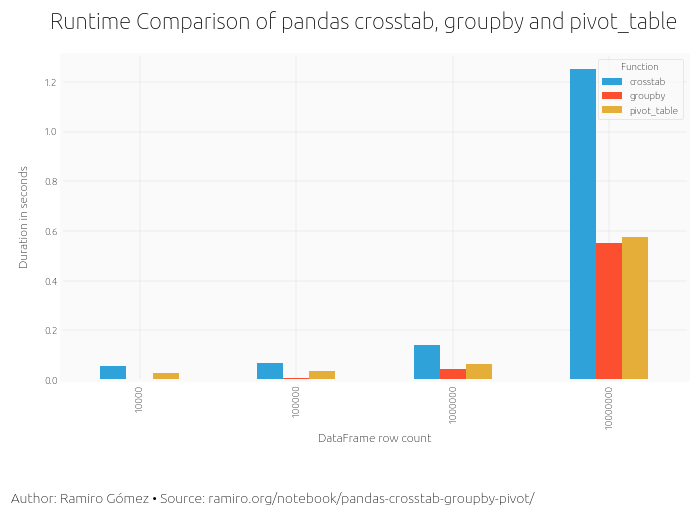

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
pd.DataFrame(measurements).groupby(['Row count', 'Function']).duration.mean().unstack().plot(ax=ax, kind='bar')

ax.set_xlabel('DataFrame row count')
ax.set_ylabel('Duration in seconds', labelpad=25, va='top')

fig.suptitle('Runtime Comparison of pandas crosstab, groupby and pivot_table', fontsize=22)
fig.text(0.01, -0.15, 'Author: Ramiro Gómez • Source: ramiro.org/notebook/pandas-crosstab-groupby-pivot/', ha='left', va='center', fontsize=14);

For smaller data frames the `groupby` variant is clearly the fastest. For larger record counts the runtime differences between `groupby` and `pivot_table` become less pronounced, both of them are significantly faster than `crosstab`. In this particular case, where all three variants produce equivalent results, `groupby` looks like the best choice. Obviously, runtime may not be your main concern and other factors such as data types and missing values could impact the runtime in favor of the other variants. Better measure than guess and you should end up with a sane choice.